# Classifier on Features
1. Extract final features from resnet for each tile
2. The 2048 dim features from each tile are mapped to a 1 dim feature by using a convolutional layer.
3. The output is vector of length num_tiles. Then we take the min and max 5 values.
4. the 10 values are fed into an MLP with 200-100-2 nodes

Differences:
* Not using full number of tiles (/10)
* Not sampling tiles using fixed grid, just randomly
* What tiles are scanned at 20x or 40x resolution?

In [1]:
import os
import sys
import glob
import random
import pickle
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.models as models


%reload_ext autoreload
%autoreload 2
%matplotlib inline

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
print(torch.cuda.current_device())
cuda=True

# Base Directory where data is stored
base_data_dir = ''
ex_img = '/media/rene/Data/camelyon_out/global_label_tiles_224_10/train/normal/Normal_029/Normal_029_1'


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0
0


In [2]:
resnet50 = models.resnet50(pretrained=True)
resnet50.cuda()
resnet50_feat = nn.Sequential(*list(resnet50.children())[:-1])

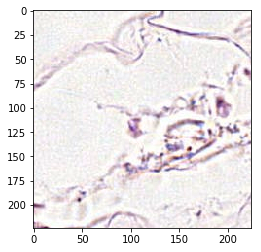

In [42]:
imshow(Image.open(ex_img))

In [102]:
feat = np.load('/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_014.npy')
print(feat.shape)

(1355, 2048)


# NN for the features

In [196]:
# Data Loader
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import os
import glob
from random import shuffle

def stack_var_size(sample, pad_length=False):
#     print(sample[0].shape)
#     print(sample[1].shape)
    if len(sample[0].shape) == 2: # we have a 1 Dimensional series. Assume format is [channels, length]
        # pad the length to with 0s to be the maximum length of any in the batch
        if not pad_length:
            pad_length = max([obs.shape[-1] for obs in sample])
        padded_sample = []
        for obs in sample:
            result = np.zeros((sample[0].shape[0], pad_length))
            result[:obs.shape[0],:obs.shape[1]] = obs
            padded_sample.append(result)

    elif len(sample[0].shape) == 3: # we have an image
        print('error images batch gen not implemented yet', batch[0].shape)
    elif len(sample[0].shape) == 1:
        return np.stack(sample)
    return np.array(padded_sample)

def np_collate_var_size(batch):
    "Puts each data field into a tensor with outer dimension batch size. Must be numpy format input"
    pad_length = False
    if isinstance(batch[0], (np.ndarray, np.generic)):
        return stack_var_size(batch, pad_length)
    elif isinstance(batch[0], int):
        return torch.LongTensor(batch)
    elif isinstance(batch[0], float):
        return torch.DoubleTensor(batch)
    elif isinstance(batch[0], (str, bytes)):
        return batch
    elif isinstance(batch, collections.Sequence):
        transposed = zip(*batch)
        return [np_collate_var_size(samples) for samples in transposed]
    raise TypeError(("batch must contain numpy array or numbers, numbers; found {}"
                     .format(type(batch[0]))))

class FeaturesDataset(Dataset):
    """Reading in extracted features from resnet50. Input data is backwards [features, observations]. Samp
    """
    SEED = 101
    random.seed(SEED)

    def __init__(self, data_loc, samp=False):
        self.all_data = glob.glob(data_loc+'/**/*.npy', recursive=True)
        if samp:
            random.shuffle(self.all_data)
            self.all_data = self.all_data[0:10]
            print(self.all_data)
                
    def __getitem__(self, index):
        """This returns an individual numpy array for the data and label"""
        feat = np.load(self.all_data[index])

        # Convert to proper dim ordering. Leave as numpy for collate function
        feat = np.swapaxes(feat,0,1)
                              
        # get the label
        if 'normal' in self.all_data[index]:
            label = 0
        elif 'tumor' in self.all_data[index]:
            label = 1
        else: # how will the test set work? Are these labels just ignored?
            label = 9 
        label = np.expand_dims(label, 0) # what is this???
        label = np.expand_dims(label, 0)

        return feat, label

    def __len__(self):
        return len(self.all_data)

In [197]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.sampler as sampler

# input dim ordering in pytorch is batch_size, channels, (other dims)

class ChowderNet(nn.Module):
    def __init__(self):
        super(ChowderNet, self).__init__()
        # (channelsin=2048, kernel_size=1, this only spans the channels)
        self.conv1 = nn.Conv1d(2048, 1, kernel_size=1, stride=1, padding=0)        
        self.fc1 = nn.Linear(10, 200)
#         self.s1 = nn.Sigmoid()
        self.s1 = nn.ReLU()
        self.fc1_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 100)
#         self.s2 = nn.Sigmoid()
        self.s2 = nn.ReLU()
        self.fc2_drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(100, 1)
        self.s3 = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)        
        max_5 = torch.topk(x, k=5, largest=True)
        min_5 = torch.topk(x, k=5, largest=False)
        max_5 = max_5[0]
        min_5 = min_5[0]
        x = torch.cat((max_5, min_5), 2)
        
        # Fully connected:
        x = self.fc1(x)
        x = self.fc1_drop(x)
        x = self.s1(x)
        x = self.fc2(x)
        x = self.fc2_drop(x)
        x = self.s2(x)
        x = self.fc3(x)
        x = self.s3(x)
        return x
    

https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3
https://github.com/pytorch/pytorch/blob/476d85dd3f8ee48f6affc836d5c7fbd8ccfab200/torch/utils/data/dataloader.py#L63
https://github.com/fastai/fastai/blob/master/fastai/dataloader.py

In [205]:
train_loc = '/media/rene/Data/camelyon_out/global_label_features_224_10/train'
valid_loc = '/media/rene/Data/camelyon_out/global_label_features_224_10/valid'

train_dataset = FeaturesDataset(train_loc, samp=True)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1, collate_fn=np_collate_var_size)

valid_dataset = FeaturesDataset(valid_loc, samp=True)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True, num_workers=1, collate_fn=np_collate_var_size)

['/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_050.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/normal/Normal_001.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/Tumor_053.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/tumor_096.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/normal/Normal_057.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/normal/Normal_074.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/normal/Normal_124.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/normal/Normal_142.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/normal/Normal_082.npy', '/media/rene/Data/camelyon_out/global_label_features_224_10/train/tumor/tumor_103.npy']
['/media/rene/Data/camelyon_out/global_label_features_224_10/valid/normal/Normal_011.npy', '/media/rene/Dat

In [208]:
import collections

epochs = 30

model = ChowderNet()
model.cuda()
loss_fn = nn.BCELoss()  
# optimizer = torch.optim.Adam([
#                             {'params': model.conv1.weight, 'weight_decay': .5},
#                             {'params': model.conv1.bias, 'weight_decay': .5},
#                             {'params': model.fc1.weight, 'weight_decay': 0},
#                             {'params': model.fc1.bias, 'weight_decay': 0},
#                             {'params': model.fc2.weight, 'weight_decay': 0},
#                             {'params': model.fc2.bias, 'weight_decay': 0},
#                             ], lr = 0.001)

optimizer = torch.optim.Adam(model.parameters(), lr = .001)

def get_valid_loss():
    # Now get the validation loss
    model.eval()
    valid_loss = 0
    correct = 0
    num_data=0
    for data, target in valid_loader:
        num_data+=len(target)
        data = torch.from_numpy(np.array(data)).type(torch.FloatTensor)
        target = torch.from_numpy(target).type(torch.FloatTensor)
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += loss_fn(output, target)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        target = target.type(torch.cuda.LongTensor)
        
#         print(np.column_stack((np.squeeze(target.data.cpu().numpy()), np.squeeze(output.data.cpu().numpy()))))

        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    valid_loss /= num_data
    valid_acc = 100. * correct / num_data
    return valid_loss, valid_acc   

for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = torch.from_numpy(np.array(data)).type(torch.FloatTensor)
        target = torch.from_numpy(target).type(torch.FloatTensor) 
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
#         print('target: ', target.data.cpu().numpy())
#         print('output: ', output.data.cpu().numpy())

    valid_loss, valid_acc = get_valid_loss()
    print('-------Epoch: ', epoch)
    print('train loss: ', loss.data.cpu().numpy())
    print('valid_loss: ', valid_loss.data[0])
    print('valid_acc: ', valid_acc)
    
    print('train ----')
#     print(np.column_stack((np.squeeze(target.data.cpu().numpy()), np.squeeze(output.data.cpu().numpy())[0])))

# final validation loss
valid_loss, valid_acc = get_valid_loss()
print(valid_loss, valid_acc)

-------Epoch:  1
train loss:  [0.7023549]
valid_loss:  0.06881501525640488
valid_acc:  40.0
train ----
-------Epoch:  2
train loss:  [0.7014066]
valid_loss:  0.06902769207954407
valid_acc:  40.0
train ----
-------Epoch:  3
train loss:  [0.6979276]
valid_loss:  0.06923027336597443
valid_acc:  40.0
train ----
-------Epoch:  4
train loss:  [0.70169264]
valid_loss:  0.06973809748888016
valid_acc:  40.0
train ----
-------Epoch:  5
train loss:  [0.70201206]
valid_loss:  0.07004091143608093
valid_acc:  40.0
train ----
-------Epoch:  6
train loss:  [0.6816155]
valid_loss:  0.07086111605167389
valid_acc:  40.0
train ----
-------Epoch:  7
train loss:  [0.68648213]
valid_loss:  0.07234840840101242
valid_acc:  40.0
train ----
-------Epoch:  8
train loss:  [0.6854464]
valid_loss:  0.07382851094007492
valid_acc:  40.0
train ----
-------Epoch:  9
train loss:  [0.72795117]
valid_loss:  0.07374724745750427
valid_acc:  40.0
train ----
-------Epoch:  10
train loss:  [0.7034091]
valid_loss:  0.07286956161